In [1]:
import import_ipynb
# This line imports the MGA_functions notebook which contains 
# the MGA_solver function and other plotting functions
from MGA_functions import *

importing Jupyter notebook from MGA_functions.ipynb


In [2]:
import pypsa
import pandas as pd
import time
import cufflinks as cf
import plotly.offline as pltly
pltly.init_notebook_mode(connected=True)

In [3]:
hours_in_2018=pd.date_range('2017-07-01T00:00Z','2017-07-05T23:00Z',freq='H') #'2017-12-31T23:00Z'
network = pypsa.Network()
network.set_snapshots(hours_in_2018)

In [4]:
def annuity(n,r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20,0.05)*20 = 1.6"""

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [5]:
# load electricity demand data
df_elec = pd.read_csv('data/Total Load - Day Ahead - 2017-2018 - DK,SWE,NO.csv',sep=',',index_col=0) # in MWh
CF_elec_dnk = df_elec['Actual Total Load [MW] - Denmark (DK)'][[hour.strftime("%Y-%m-%d %H:%M:%S+00:00") for hour in network.snapshots]].tolist()

CF_elec_nor = df_elec['Actual Total Load [MW] - Norway (NO)'][[hour.strftime("%Y-%m-%d %H:%M:%S+00:00") for hour in network.snapshots]].tolist()

CF_elec_swe = df_elec['Actual Total Load [MW] - Sweden (SE)'][[hour.strftime("%Y-%m-%d %H:%M:%S+00:00") for hour in network.snapshots]].tolist()

df_elec_list = [CF_elec_dnk,CF_elec_nor,CF_elec_swe]

In [6]:
# Wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv',sep=';',index_col=0)
CF_wind_dnk=df_onshorewind['DNK'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
CF_wind_nor=df_onshorewind['NOR'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
CF_wind_swe=df_onshorewind['SWE'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

CF_wind_list = [CF_wind_dnk,CF_wind_nor,CF_wind_swe]

In [7]:
# add solar PV generator
df_solar = pd.read_csv('data/pv_optimal.csv',sep=';',index_col=0)
CF_solar_dnk=df_solar['DNK'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
CF_solar_nor=df_solar['NOR'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
CF_solar_swe=df_solar['SWE'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

CF_solar_list = [CF_solar_dnk,CF_solar_nor,CF_solar_swe]

In [8]:
#add three buses
n_buses = 3

for i in range(n_buses):
    network.add("Bus","My bus {}".format(i),
                #v_nom=20.,
               x = i,
               y = i%2)

In [9]:

#add three lines in a ring
for i in range(n_buses):
    network.add("Line","My line {}".format(i),
                bus0="My bus {}".format(i),
                bus1="My bus {}".format((i+1)%n_buses),
                x=0.1,
                r=0.3,
                s_nom_extendable=True,
               capital_cost=75753)



(<matplotlib.collections.PathCollection at 0x20d0e957710>,
 <matplotlib.collections.LineCollection at 0x20d0e957240>)

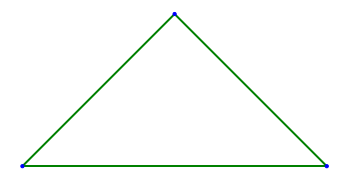

In [106]:
network.plot()

In [10]:
# Add dispatchable generator
capital_cost_OCGT=annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost=200   #21.6 # in €/MWh_th
efficiency=0.39
marginal_cost_OCGT=fuel_cost/efficiency # in €/MWh_el
for i in range(n_buses):
    network.add("Generator","gas {}".format(i),
                bus="My bus {}".format(i),
                committable=True,
                capital_cost=capital_cost_OCGT,
                marginal_cost=marginal_cost_OCGT,
               p_nom_extendable=True)
               
                

In [11]:
# Add wind 
capital_cost_onshorewind=annuity(30,0.07)*910000*(1+0.033) # in €/MW
for i in range(n_buses):
    network.add("Generator","wind {}".format(i),
                bus="My bus {}".format(i),
               marginal_cost=0,
                capital_cost = capital_cost_onshorewind,
               committable=True,
               p_nom_extendable=True,
               p_max_pu=CF_wind_list[i])    

In [12]:
# Add solar
capital_cost_solar=annuity(25,0.07)*425000*(1+0.03) # in €/MW
for i in range(n_buses):
    network.add("Generator","solar {}".format(i),
                bus="My bus {}".format(i),
               marginal_cost=0,
                capital_cost = capital_cost_solar,
               committable=True,
               p_nom_extendable=True,
               p_max_pu=CF_solar_list[i]) 

In [13]:
# Add loads
for i in range(n_buses):
    network.add("Load","load {}".format(i),
                bus="My bus {}".format(i),
                p_set=df_elec_list[i])

In [114]:
network.lopf(network.snapshots, solver_name='gurobi')

INFO:pypsa.pf:Slack bus for sub-network 0 is My bus 0
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['gas 0', 'gas 1', 'gas 2', 'wind 0', 'wind 1', 'wind 2', 'solar 0',
       'solar 1', 'solar 2'],
      dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x11533_copy
  Lower bound: 10971348978.685438
  Upper bound: 10971348978.685438
  Number of objectives: 1
  Number of constraints: 23809
  Number of variables: 11533
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 11533
  Number of nonzeros: 48725
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

('ok', 'optimal')

In [14]:
network.export_to_hdf5('Scandinavia')

INFO:pypsa.io:Exported network Scandinavia has lines, loads, buses, generators


In [115]:
network.generators.p_nom_opt

gas 0       3677.465915
gas 1      10795.539239
gas 2      13621.339096
wind 0         0.000000
wind 1     19366.512934
wind 2         0.000000
solar 0     8020.816334
solar 1    19932.586533
solar 2    34500.389598
Name: p_nom_opt, dtype: float64

In [116]:
network.lines.s_nom_opt

My line 0    154.449902
My line 1    250.553065
My line 2     96.103163
Name: s_nom_opt, dtype: float64

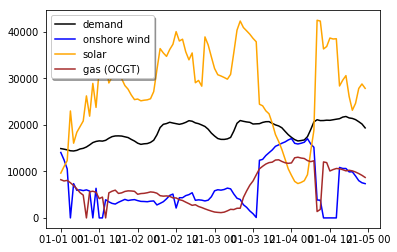

In [23]:
import matplotlib.pyplot as plt

plt.plot(network.loads_t.p['load 1'][0:96], color='black', label='demand')
plt.plot(network.generators_t.p['wind 0'][0:96], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['wind 1'][0:96], color='orange', label='solar')
plt.plot(network.generators_t.p['wind 2'][0:96], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')

In [57]:
load_distribution = network.loads_t.p_set.loc[network.snapshots[0]].groupby(network.loads.bus).sum().reindex(network.buses.index,fill_value=0.)



fig = dict(data=[],layout=dict(width=700,height=700))

fig = network.iplot(bus_sizes=0.005*load_distribution, fig=fig,
                     bus_text='Load at bus ' + network.buses.index + ': ' + round(load_distribution).values.astype(str) + ' MW',
                     title="Load distribution",
                     line_text='Line ' + network.lines.index)


C:\Users\Tim\Anaconda3\lib\site-packages\pypsa\plot.py:546: FutureWarning:

the 'labels' keyword is deprecated, use 'codes' instead



In [58]:
type(load_distribution)

pandas.core.series.Series

In [54]:
test = pd.DataFrame([sum(network.loads_t.p.iloc[:,i]) for i in range(3)],
                    index = ['My bus 0', 'My bus 1' , 'My Bus 2'])

In [59]:
type (test)

pandas.core.frame.DataFrame

In [ ]:
pd.